In [2]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

def load_images(path, size=(256,256)):
    data_list = list()

    for filename in listdir(path):
        pixels = load_img(path + filename, target_size=size)
        pixels = img_to_array(pixels)
        data_list.append(pixels)
    return asarray(data_list)
 
path = 'cats/'
dataA1 = load_images(path + 'trainA/')
dataAB = load_images(path + 'testA/')
dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)

dataB1 = load_images(path + 'trainB/')
dataB2 = load_images(path + 'testB/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)

filename = 'horse2zebra_256.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Loaded dataA:  (2225, 256, 256, 3)
Loaded dataB:  (2225, 256, 256, 3)
Saved dataset:  horse2zebra_256.npz


Loaded:  (2225, 256, 256, 3) (2225, 256, 256, 3)


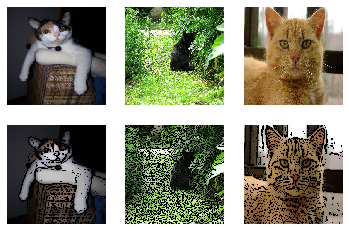

In [3]:
from numpy import load
from matplotlib import pyplot

data = load('horse2zebra_256.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)

n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(dataA[i].astype('uint8'))

for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

In [4]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
layer = InstanceNormalization(axis=-1)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    model = Model(in_image, patch_out)
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

In [6]:
def resnet_block(n_filters, input_layer):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Concatenate()([g, input_layer])
    return g

In [7]:
def define_generator(image_shape, n_resnet=9):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    model = Model(in_image, out_image)
    return model

In [8]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    output_f = g_model_2(gen1_out)
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

In [9]:
def load_real_samples(filename):
    data = load(filename)
    X1, X2 = data['arr_0'], data['arr_1']
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [10]:
def generate_real_samples(dataset, n_samples, patch_shape):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

In [11]:
def generate_fake_samples(g_model, dataset, patch_shape):
    X = g_model.predict(dataset)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [12]:
def save_models(step, g_model_AtoB, g_model_BtoA):
    filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [13]:
def summarize_performance(step, g_model, trainX, name, n_samples=5):
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i])
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    pyplot.savefig(filename1)
    pyplot.close()

In [14]:
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            selected.append(image)
        else:
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)

In [15]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
	n_epochs, n_batch, = 1, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 1) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

In [16]:
import tensorflow as tf
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.initializers import RandomNormal
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import Input
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import Conv2DTranspose
from tensorflow.python.keras.layers import LeakyReLU
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

dataset = load_real_samples('horse2zebra_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (2225, 256, 256, 3) (2225, 256, 256, 3)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
>1, dA[0.997,0.823] dB[2.286,0.678] g[22.189,21.044]
>2, dA[3.181,0.974] dB[1.439,1.358] g[18.622,18.469]
>3, dA[4.232,0.902] dB[2.054,1.540] g[23.771,20.643]
>4, dA[2.367,1.139] dB[2.978,2.443] g[17.507,16.945]
>5, dA[2.502,0.871] dB[1.350,4.635] g[25.546,18.226]
>6, dA[3.616,3.507] dB[1.359,6.699] g[29.078,23.763]
>7, dA[5.281,4.614] dB[1.167,4.147] g[19.142,25.577]
>8, dA[7.469,2.164] dB[1.159,2.974] g[21.231,23.092]
>9, dA[2.598,1.643] dB[0.927,2.863] g[17.572,16.729]
>10, dA[1.154,1.083] dB[0.547,1.358] g[14.614,15.813]
>11, dA[0.687,0.864] dB[1.110,1.170] g[19.183,18.640]
>12, dA[0.818,0.868] dB[1.406,1.275] g[13.702,12.538]
>13, dA[0.717,1.083] dB[1.094,0.693] g[13.484,14.834]
>14, dA[1.052,0.671] dB[0.761,1.247] g[12.385,11.599]
>15, dA[0.687,0.517] dB[0.672,1.082] g[12.261,11.067]
>16, dA[0.557,0.337] dB[0.818,0.64

>136, dA[0.236,0.158] dB[0.186,0.171] g[7.508,7.995]
>137, dA[0.315,0.174] dB[0.112,0.151] g[7.901,8.655]
>138, dA[0.257,0.275] dB[0.198,0.180] g[7.619,8.349]
>139, dA[0.261,0.090] dB[0.090,0.117] g[8.573,8.893]
>140, dA[0.140,0.202] dB[0.134,0.078] g[6.303,6.271]
>141, dA[0.143,0.115] dB[0.067,0.211] g[5.696,6.479]
>142, dA[0.298,0.254] dB[0.271,0.147] g[7.805,6.726]
>143, dA[0.241,0.252] dB[0.101,0.225] g[7.371,6.786]
>144, dA[0.159,0.155] dB[0.287,0.078] g[7.249,7.784]
>145, dA[0.248,0.256] dB[0.186,0.173] g[7.983,7.628]
>146, dA[0.195,0.152] dB[0.217,0.281] g[7.172,7.910]
>147, dA[0.265,0.200] dB[0.204,0.297] g[7.847,7.926]
>148, dA[0.140,0.178] dB[0.329,0.225] g[6.153,6.250]
>149, dA[0.216,0.119] dB[0.152,0.238] g[6.384,6.519]
>150, dA[0.177,0.287] dB[0.198,0.128] g[10.307,11.536]
>151, dA[0.170,0.080] dB[0.150,0.187] g[6.864,7.743]
>152, dA[0.170,0.088] dB[0.138,0.091] g[8.445,8.146]
>153, dA[0.121,0.272] dB[0.237,0.163] g[7.358,6.732]
>154, dA[0.216,0.213] dB[0.096,0.244] g[5.85

>290, dA[0.193,0.131] dB[0.205,0.136] g[6.701,7.089]
>291, dA[0.112,0.093] dB[0.190,0.239] g[6.692,7.828]
>292, dA[0.195,0.199] dB[0.189,0.106] g[8.236,7.190]
>293, dA[0.211,0.230] dB[0.140,0.148] g[7.688,6.409]
>294, dA[0.199,0.173] dB[0.067,0.064] g[12.060,13.000]
>295, dA[0.217,0.179] dB[0.164,0.059] g[5.683,5.272]
>296, dA[0.183,0.148] dB[0.109,0.050] g[6.854,6.440]
>297, dA[0.160,0.153] dB[0.207,0.241] g[5.343,5.556]
>298, dA[0.194,0.122] dB[0.056,0.171] g[7.465,7.186]
>299, dA[0.094,0.101] dB[0.147,0.086] g[9.758,10.168]
>300, dA[0.102,0.153] dB[0.144,0.083] g[8.274,8.146]
>301, dA[0.230,0.190] dB[0.213,0.175] g[7.251,6.717]
>302, dA[0.138,0.071] dB[0.047,0.142] g[6.892,7.000]
>303, dA[0.144,0.231] dB[0.246,0.045] g[7.493,7.873]
>304, dA[0.150,0.078] dB[0.076,0.140] g[9.653,9.255]
>305, dA[0.165,0.125] dB[0.212,0.079] g[8.135,8.691]
>306, dA[0.178,0.228] dB[0.050,0.271] g[9.019,8.992]
>307, dA[0.219,0.108] dB[0.140,0.071] g[10.419,9.081]
>308, dA[0.176,0.102] dB[0.192,0.074] g[5.

>444, dA[0.128,0.294] dB[0.092,0.284] g[8.931,9.730]
>445, dA[0.139,0.202] dB[0.315,0.145] g[6.552,5.793]
>446, dA[0.184,0.158] dB[0.097,0.112] g[6.886,7.301]
>447, dA[0.104,0.301] dB[0.112,0.228] g[6.870,6.124]
>448, dA[0.203,0.056] dB[0.156,0.047] g[7.465,7.944]
>449, dA[0.153,0.172] dB[0.083,0.040] g[8.629,7.326]
>450, dA[0.049,0.145] dB[0.686,0.223] g[8.991,10.184]
>451, dA[0.249,0.164] dB[0.065,0.202] g[8.008,7.855]
>452, dA[0.097,0.060] dB[0.061,0.089] g[8.083,8.683]
>453, dA[0.178,0.189] dB[0.119,0.085] g[11.055,10.139]
>454, dA[0.206,0.255] dB[0.086,0.074] g[6.703,6.049]
>455, dA[0.157,0.139] dB[0.199,0.151] g[8.309,8.275]
>456, dA[0.186,0.184] dB[0.061,0.031] g[9.126,7.359]
>457, dA[0.170,0.108] dB[0.205,0.073] g[8.377,6.626]
>458, dA[0.156,0.267] dB[0.138,0.219] g[6.828,6.509]
>459, dA[0.151,0.127] dB[0.168,0.142] g[7.075,6.939]
>460, dA[0.240,0.189] dB[0.379,0.171] g[6.223,5.554]
>461, dA[0.194,0.179] dB[0.051,0.137] g[7.222,6.573]
>462, dA[0.114,0.176] dB[0.086,0.033] g[9.8

>599, dA[0.277,0.138] dB[0.159,0.120] g[5.555,5.755]
>600, dA[0.098,0.078] dB[0.295,0.218] g[7.218,7.701]
>601, dA[0.055,0.097] dB[0.049,0.154] g[8.278,8.229]
>602, dA[0.150,0.140] dB[0.340,0.133] g[7.668,8.356]
>603, dA[0.195,0.195] dB[0.205,0.145] g[4.788,6.146]
>604, dA[0.036,0.050] dB[0.096,0.097] g[11.669,14.024]
>605, dA[0.399,0.086] dB[0.108,0.093] g[4.512,4.939]
>606, dA[0.185,0.336] dB[0.054,0.087] g[8.958,7.472]
>607, dA[0.149,0.179] dB[0.449,0.258] g[6.997,7.063]
>608, dA[0.180,0.185] dB[0.238,0.074] g[5.980,5.600]
>609, dA[0.188,0.135] dB[0.130,0.276] g[6.627,6.358]
>610, dA[0.143,0.138] dB[0.047,0.070] g[7.891,7.504]
>611, dA[0.093,0.212] dB[0.311,0.084] g[5.644,6.369]
>612, dA[0.231,0.143] dB[0.030,0.147] g[5.921,5.515]
>613, dA[0.146,0.181] dB[0.064,0.071] g[7.420,6.385]
>614, dA[0.135,0.172] dB[0.182,0.030] g[6.305,5.870]
>615, dA[0.026,0.068] dB[0.037,0.166] g[9.696,9.326]
>616, dA[0.254,0.095] dB[0.035,0.013] g[7.657,7.043]
>617, dA[0.074,0.241] dB[0.564,0.155] g[8.28

>754, dA[0.199,0.219] dB[0.392,0.099] g[6.364,5.545]
>755, dA[0.165,0.270] dB[0.031,0.275] g[5.386,5.506]
>756, dA[0.286,0.259] dB[0.147,0.055] g[7.339,7.524]
>757, dA[0.275,0.112] dB[0.040,0.049] g[12.608,10.588]
>758, dA[0.170,0.156] dB[0.157,0.112] g[5.379,5.138]
>759, dA[0.236,0.306] dB[0.021,0.029] g[6.996,6.851]
>760, dA[0.133,0.156] dB[0.384,0.090] g[7.793,6.263]
>761, dA[0.079,0.080] dB[0.049,0.095] g[9.023,10.371]
>762, dA[0.189,0.176] dB[0.185,0.022] g[9.143,7.596]
>763, dA[0.274,0.121] dB[0.105,0.023] g[7.528,6.269]
>764, dA[0.094,0.200] dB[0.156,0.104] g[6.214,5.675]
>765, dA[0.148,0.129] dB[0.054,0.080] g[6.716,5.944]
>766, dA[0.198,0.176] dB[0.059,0.032] g[8.728,6.816]
>767, dA[0.152,0.198] dB[0.041,0.033] g[6.821,5.305]
>768, dA[0.161,0.118] dB[0.078,0.187] g[6.657,5.892]
>769, dA[0.067,0.108] dB[0.068,0.014] g[6.163,5.711]
>770, dA[0.083,0.102] dB[0.102,0.009] g[6.972,6.763]
>771, dA[0.152,0.166] dB[0.066,0.059] g[8.666,8.394]
>772, dA[0.261,0.204] dB[0.056,0.068] g[8.5

>909, dA[0.108,0.082] dB[0.252,0.147] g[5.927,6.387]
>910, dA[0.218,0.098] dB[0.035,0.124] g[5.715,6.612]
>911, dA[0.045,0.091] dB[0.048,0.013] g[6.957,7.029]
>912, dA[0.050,0.070] dB[0.168,0.019] g[7.580,7.097]
>913, dA[0.307,0.078] dB[0.083,0.555] g[4.367,6.115]
>914, dA[0.111,0.096] dB[0.074,0.070] g[5.565,5.257]
>915, dA[0.082,0.407] dB[0.122,0.103] g[6.259,5.152]
>916, dA[0.163,0.032] dB[0.056,0.044] g[6.718,6.456]
>917, dA[0.055,0.142] dB[0.212,0.184] g[4.917,4.539]
>918, dA[0.263,0.099] dB[0.232,0.305] g[5.733,5.944]
>919, dA[0.040,0.087] dB[0.134,0.043] g[6.967,6.736]
>920, dA[0.053,0.092] dB[0.356,0.277] g[10.407,11.534]
>921, dA[0.045,0.037] dB[0.063,0.084] g[7.723,8.998]
>922, dA[0.160,0.087] dB[0.045,0.011] g[7.314,6.937]
>923, dA[0.138,0.086] dB[0.029,0.016] g[7.317,7.690]
>924, dA[0.080,0.159] dB[0.229,0.342] g[5.921,5.339]
>925, dA[0.025,0.076] dB[0.167,0.265] g[4.303,4.401]
>926, dA[0.020,0.023] dB[0.026,0.065] g[10.011,11.024]
>927, dA[0.338,0.077] dB[0.035,0.055] g[6.

>1063, dA[0.094,0.194] dB[0.039,0.034] g[9.070,8.701]
>1064, dA[0.227,0.086] dB[0.063,0.012] g[7.381,6.286]
>1065, dA[0.111,0.200] dB[0.128,0.083] g[5.530,5.292]
>1066, dA[0.075,0.130] dB[0.035,0.057] g[5.654,6.319]
>1067, dA[0.165,0.069] dB[0.018,0.128] g[4.671,4.992]
>1068, dA[0.165,0.115] dB[0.048,0.014] g[7.647,6.032]
>1069, dA[0.065,0.188] dB[0.515,0.091] g[5.674,5.408]
>1070, dA[0.199,0.301] dB[0.220,0.133] g[7.429,7.609]
>1071, dA[0.101,0.140] dB[0.066,0.017] g[8.018,7.051]
>1072, dA[0.236,0.153] dB[0.070,0.014] g[7.339,5.758]
>1073, dA[0.179,0.184] dB[0.306,0.097] g[4.071,4.456]
>1074, dA[0.047,0.085] dB[0.028,0.109] g[9.964,10.312]
>1075, dA[0.424,0.148] dB[0.338,0.147] g[4.694,4.994]
>1076, dA[0.055,0.106] dB[0.133,0.054] g[11.569,13.748]
>1077, dA[0.335,0.078] dB[0.053,0.100] g[5.942,5.509]
>1078, dA[0.126,0.189] dB[0.134,0.103] g[7.690,7.588]
>1079, dA[0.084,0.163] dB[0.026,0.038] g[8.323,7.182]
>1080, dA[0.186,0.114] dB[0.352,0.134] g[6.311,6.842]
>1081, dA[0.229,0.149] dB

>1215, dA[0.092,0.193] dB[0.380,0.102] g[5.372,4.871]
>1216, dA[0.015,0.078] dB[0.199,0.209] g[6.765,7.349]
>1217, dA[0.479,0.079] dB[0.046,0.027] g[7.416,7.369]
>1218, dA[0.232,0.158] dB[0.191,0.028] g[7.532,6.852]
>1219, dA[0.073,0.105] dB[0.124,0.271] g[4.209,4.581]
>1220, dA[0.059,0.190] dB[0.014,0.059] g[5.694,6.048]
>1221, dA[0.054,0.020] dB[0.360,0.076] g[6.448,6.667]
>1222, dA[0.067,0.024] dB[0.154,0.158] g[5.615,6.435]
>1223, dA[0.017,0.059] dB[0.026,0.041] g[6.732,6.511]
>1224, dA[0.351,0.089] dB[0.096,0.050] g[5.398,6.330]
>1225, dA[0.160,0.289] dB[0.034,0.161] g[6.056,5.610]
>1226, dA[0.018,0.026] dB[0.185,0.015] g[8.046,7.863]
>1227, dA[0.469,0.164] dB[0.172,0.415] g[7.515,7.769]
>1228, dA[0.217,0.183] dB[0.034,0.046] g[6.839,6.411]
>1229, dA[0.307,0.189] dB[0.350,0.033] g[6.172,5.264]
>1230, dA[0.021,0.159] dB[0.197,0.235] g[4.838,4.799]
>1231, dA[0.168,0.084] dB[0.059,0.135] g[5.330,5.574]
>1232, dA[0.301,0.228] dB[0.038,0.101] g[6.567,5.393]
>1233, dA[0.158,0.301] dB[0.

>1367, dA[0.026,0.085] dB[0.035,0.012] g[12.509,13.145]
>1368, dA[0.168,0.126] dB[0.381,0.108] g[6.834,6.927]
>1369, dA[0.161,0.190] dB[0.035,0.231] g[5.971,5.955]
>1370, dA[0.181,0.317] dB[0.244,0.034] g[6.895,6.896]
>1371, dA[0.209,0.053] dB[0.073,0.280] g[5.877,6.310]
>1372, dA[0.321,0.235] dB[0.045,0.029] g[6.673,6.429]
>1373, dA[0.162,0.196] dB[0.026,0.037] g[7.051,6.774]
>1374, dA[0.166,0.163] dB[0.341,0.094] g[5.447,5.578]
>1375, dA[0.206,0.106] dB[0.049,0.013] g[5.493,5.959]
>1376, dA[0.115,0.287] dB[0.033,0.011] g[6.572,6.676]
>1377, dA[0.029,0.021] dB[0.018,0.048] g[6.702,7.853]
>1378, dA[0.440,0.065] dB[0.236,0.569] g[3.589,4.264]
>1379, dA[0.235,0.159] dB[0.237,0.123] g[4.047,4.749]
>1380, dA[0.071,0.199] dB[0.022,0.056] g[6.091,5.123]
>1381, dA[0.030,0.050] dB[0.303,0.062] g[8.473,8.639]
>1382, dA[0.210,0.152] dB[0.192,0.153] g[5.094,5.220]
>1383, dA[0.028,0.091] dB[0.022,0.205] g[6.700,7.415]
>1384, dA[0.280,0.075] dB[0.055,0.037] g[6.112,5.911]
>1385, dA[0.173,0.196] dB[

>1519, dA[0.047,0.117] dB[0.045,0.031] g[8.295,7.902]
>1520, dA[0.140,0.143] dB[0.023,0.009] g[7.591,6.063]
>1521, dA[0.183,0.216] dB[0.336,0.124] g[8.426,7.587]
>1522, dA[0.114,0.140] dB[0.096,0.193] g[5.360,5.417]
>1523, dA[0.052,0.094] dB[0.015,0.058] g[6.088,6.587]
>1524, dA[0.397,0.077] dB[0.421,0.077] g[4.139,4.567]
>1525, dA[0.144,0.120] dB[0.022,0.121] g[6.015,5.626]
>1526, dA[0.175,0.162] dB[0.109,0.049] g[6.511,6.032]
>1527, dA[0.022,0.093] dB[0.116,0.112] g[8.783,10.180]
>1528, dA[0.238,0.104] dB[0.039,0.038] g[6.161,6.456]
>1529, dA[0.134,0.257] dB[0.077,0.029] g[5.447,6.934]
>1530, dA[0.055,0.103] dB[0.072,0.101] g[5.385,6.301]
>1531, dA[0.319,0.087] dB[0.137,0.075] g[6.545,6.869]
>1532, dA[0.123,0.160] dB[0.020,0.359] g[5.802,6.480]
>1533, dA[0.263,0.150] dB[0.018,0.014] g[6.483,7.313]
>1534, dA[0.096,0.185] dB[0.256,0.053] g[7.603,5.717]
>1535, dA[0.169,0.184] dB[0.071,0.417] g[5.904,5.817]
>1536, dA[0.154,0.244] dB[0.030,0.010] g[7.383,7.463]
>1537, dA[0.119,0.099] dB[0

>1671, dA[0.211,0.087] dB[0.458,0.027] g[4.923,4.838]
>1672, dA[0.032,0.297] dB[0.134,0.473] g[4.934,5.020]
>1673, dA[0.054,0.061] dB[0.025,0.044] g[6.576,6.574]
>1674, dA[0.145,0.042] dB[0.162,0.034] g[7.834,8.036]
>1675, dA[0.194,0.361] dB[0.135,0.056] g[6.103,6.832]
>1676, dA[0.267,0.356] dB[0.076,0.212] g[6.463,6.610]
>1677, dA[0.071,0.021] dB[0.024,0.017] g[7.596,8.169]
>1678, dA[0.451,0.093] dB[0.562,0.110] g[5.824,6.148]
>1679, dA[0.184,0.123] dB[0.186,0.126] g[6.290,6.324]
>1680, dA[0.064,0.117] dB[0.020,0.122] g[5.897,7.214]
>1681, dA[0.380,0.026] dB[0.034,0.107] g[4.711,5.446]
>1682, dA[0.222,0.171] dB[0.473,0.059] g[7.064,7.237]
>1683, dA[0.096,0.326] dB[0.234,0.091] g[4.620,4.423]
>1684, dA[0.104,0.143] dB[0.116,0.308] g[5.444,6.382]
>1685, dA[0.156,0.165] dB[0.121,0.245] g[7.428,8.629]
>1686, dA[0.126,0.084] dB[0.219,0.242] g[4.565,4.876]
>1687, dA[0.021,0.041] dB[0.208,0.111] g[6.353,6.777]
>1688, dA[0.183,0.154] dB[0.193,0.118] g[4.011,4.247]
>1689, dA[0.070,0.111] dB[0.

>1823, dA[0.307,0.082] dB[0.196,0.017] g[4.956,5.186]
>1824, dA[0.269,0.095] dB[0.141,0.053] g[4.627,4.942]
>1825, dA[0.106,0.191] dB[0.032,0.160] g[4.558,5.356]
>1826, dA[0.104,0.248] dB[0.092,0.037] g[9.687,8.482]
>1827, dA[0.128,0.138] dB[0.235,0.157] g[4.665,4.868]
>1828, dA[0.200,0.125] dB[0.130,0.045] g[5.105,5.642]
>1829, dA[0.137,0.144] dB[0.084,0.015] g[6.057,6.005]
>1830, dA[0.279,0.188] dB[0.145,0.146] g[3.469,4.639]
>1831, dA[0.175,0.145] dB[0.015,0.034] g[6.441,5.753]
>1832, dA[0.128,0.233] dB[0.191,0.401] g[4.378,4.260]
>1833, dA[0.034,0.053] dB[0.032,0.049] g[6.124,7.272]
>1834, dA[0.195,0.063] dB[0.335,0.028] g[7.206,8.522]
>1835, dA[0.168,0.207] dB[0.019,0.333] g[5.522,5.947]
>1836, dA[0.085,0.254] dB[0.200,0.045] g[3.712,3.574]
>1837, dA[0.241,0.132] dB[0.036,0.163] g[6.003,6.512]
>1838, dA[0.172,0.092] dB[0.037,0.010] g[6.519,5.556]
>1839, dA[0.062,0.107] dB[0.124,0.021] g[7.586,7.015]
>1840, dA[0.082,0.229] dB[0.285,0.164] g[5.046,5.211]
>1841, dA[0.151,0.072] dB[0.

>1975, dA[0.018,0.028] dB[0.286,0.096] g[9.417,11.121]
>1976, dA[0.188,0.106] dB[0.105,0.475] g[4.308,5.024]
>1977, dA[0.149,0.352] dB[0.048,0.024] g[6.855,6.886]
>1978, dA[0.046,0.018] dB[0.398,0.196] g[5.387,6.389]
>1979, dA[0.046,0.020] dB[0.014,0.165] g[7.438,8.985]
>1980, dA[0.281,0.180] dB[0.282,0.218] g[4.691,4.931]
>1981, dA[0.120,0.159] dB[0.138,0.077] g[5.172,5.523]
>1982, dA[0.059,0.116] dB[0.042,0.116] g[5.360,5.593]
>1983, dA[0.052,0.053] dB[0.027,0.033] g[6.511,7.567]
>1984, dA[0.174,0.068] dB[0.149,0.023] g[6.574,6.179]
>1985, dA[0.174,0.411] dB[0.125,0.190] g[5.486,5.077]
>1986, dA[0.316,0.063] dB[0.023,0.178] g[4.232,5.046]
>1987, dA[0.020,0.067] dB[0.132,0.184] g[7.868,10.326]
>1988, dA[0.428,0.143] dB[0.190,0.086] g[4.861,4.986]
>1989, dA[0.019,0.143] dB[0.050,0.056] g[9.585,10.587]
>1990, dA[0.245,0.104] dB[0.215,0.074] g[6.047,6.436]
>1991, dA[0.240,0.163] dB[0.107,0.094] g[4.866,5.418]
>1992, dA[0.083,0.076] dB[0.012,0.364] g[7.040,8.475]
>1993, dA[0.007,0.036] dB

>2127, dA[0.202,0.110] dB[0.096,0.046] g[6.122,5.783]
>2128, dA[0.023,0.066] dB[0.008,0.102] g[7.316,7.622]
>2129, dA[0.294,0.267] dB[0.084,0.022] g[6.646,8.060]
>2130, dA[0.155,0.077] dB[0.033,0.130] g[4.200,4.765]
>2131, dA[0.090,0.023] dB[0.033,0.038] g[5.480,5.584]
>2132, dA[0.020,0.015] dB[0.126,0.019] g[7.247,7.281]
>2133, dA[0.291,0.248] dB[0.027,0.404] g[4.994,5.391]
>2134, dA[0.056,0.235] dB[0.296,0.185] g[12.850,15.228]
>2135, dA[0.401,0.091] dB[0.052,0.095] g[5.179,4.905]
>2136, dA[0.493,0.142] dB[0.117,0.272] g[4.006,4.861]
>2137, dA[0.032,0.119] dB[0.207,0.030] g[7.553,7.639]
>2138, dA[0.278,0.306] dB[0.053,0.058] g[4.868,4.734]
>2139, dA[0.089,0.051] dB[0.035,0.104] g[6.271,6.466]
>2140, dA[0.271,0.151] dB[0.018,0.035] g[7.306,6.301]
>2141, dA[0.046,0.255] dB[0.309,0.055] g[4.703,4.615]
>2142, dA[0.149,0.098] dB[0.091,0.422] g[7.196,8.432]
>2143, dA[0.252,0.343] dB[0.476,0.119] g[4.971,4.687]
>2144, dA[0.173,0.078] dB[0.032,0.071] g[8.251,6.984]
>2145, dA[0.167,0.150] dB[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


>Saved: g_model_AtoB_002225.h5 and g_model_BtoA_002225.h5


Loaded (2225, 256, 256, 3) (2225, 256, 256, 3)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


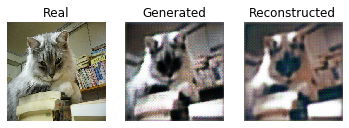

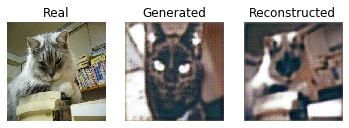

In [17]:
from tensorflow.python.keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
 
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]
 
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X
 
# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()
 
# load dataset
A_data, B_data = load_real_samples('horse2zebra_256.npz')
print('Loaded', A_data.shape, B_data.shape)
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('g_model_AtoB_000085.h5', cust)
model_BtoA = load_model('g_model_BtoA_000085.h5', cust)
# plot A->B->A
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(A_real, A_generated, A_reconstructed)

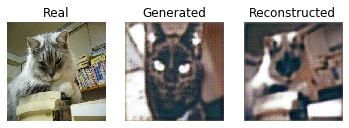

In [18]:
show_plot(A_real, A_generated, A_reconstructed)

In [19]:
A_data.shape

(2225, 256, 256, 3)

In [35]:
import cv2
import os

'''This is the command to read in the GIF. You need Videocapture which makes a cv2 Video Object.
Add your GIF file name in the parameter of this function.
'''
gif = cv2.VideoCapture('videos/11.gif')


def convert_gif_to_frames(gif):

    # Initialize the frame number and create empty frame list
    frame_num = 0
    frame_list = []
    # Loop until there are frames left
    while True:
        try:
            # Try to read a frame. Okay is a BOOL if there are frames or not
            okay, frame = gif.read()
            # Append to empty frame list
            frame_list.append(frame)
            # Break if there are no other frames to read
            if not okay:
                break
            # Increment value of the frame number by 1
            frame_num += 1
        except KeyboardInterrupt:  # press ^C to quit
            break

    return frame_list
l = convert_gif_to_frames(gif)

In [36]:
import numpy as np
img = []
for im in l:
    if im is not None:
        img.append(im[:256, :256])
img = np.stack(img)

print("stack_done!")
img_arr = model_AtoB.predict(img)
print("GAN done!")
out = cv2.VideoWriter('demo/11_2225.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, (256, 256))


stack_done!
GAN done!


In [37]:
for i in range(img_arr.shape[0]):
    fr = np.uint8((img_arr[i]*255).astype(np.uint8))
    out.write(fr)
out.release()

In [38]:
gif = cv2.VideoCapture('videos/cr.gif')
l = convert_gif_to_frames(gif)
img = []
for im in l:
    if im is not None:
        img.append(im[:256, :256])
img = np.stack(img)

print("stack_done!")
img_arr = model_BtoA.predict(img)
print("GAN done!")
out = cv2.VideoWriter('demo/cr.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, (256, 256))
for i in range(img_arr.shape[0]):
    fr = np.uint8((img_arr[i]*255).astype(np.uint8))
    out.write(fr)
out.release()

stack_done!
GAN done!


In [39]:
gif = cv2.VideoCapture('demo/11_2225.mp4')
l = convert_gif_to_frames(gif)
img = []
for im in l:
    if im is not None:
        img.append(im[:256, :256])
img = np.stack(img)

print("stack_done!")
img_arr = model_BtoA.predict(img)
print("GAN done!")
out = cv2.VideoWriter('demo/cr_11.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, (256, 256))
for i in range(img_arr.shape[0]):
    fr = np.uint8((img_arr[i]*255).astype(np.uint8))
    out.write(fr)
out.release()

stack_done!
GAN done!
